In [1]:
#Importar librerias necesarias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn



In [3]:
df = pd.read_csv('D:/nuevo/universidad/Master/Proyecto_Integrador/TSblusa.csv')
df

,SEMANA,ANO,PRENDA,UNIDADES,SEMANACORRIDA
0,1,2020,BLUSAS,38,1
1,2,2020,BLUSAS,68,2
2,3,2020,BLUSAS,73,3
3,4,2020,BLUSAS,84,4
4,5,2020,BLUSAS,119,5
...,...,...,...,...,...
128,36,2022,BLUSAS,37,142
129,37,2022,BLUSAS,52,143
130,38,2022,BLUSAS,55,144
131,39,2022,BLUSAS,48,145


In [29]:
# df = df[df["PRENDA"]=="POLOS"]
# planets[planets['year'] == 2008]

In [4]:
tam = round(len(df)*0.2)

In [5]:
# Separación datos train-test
# ==============================================================================
steps = tam
datos_train = df[:-steps]
datos_test  = df[-steps:]

Fechas train : 0 --- 105  (n=106)
Fechas test  : 106 --- 132  (n=27)


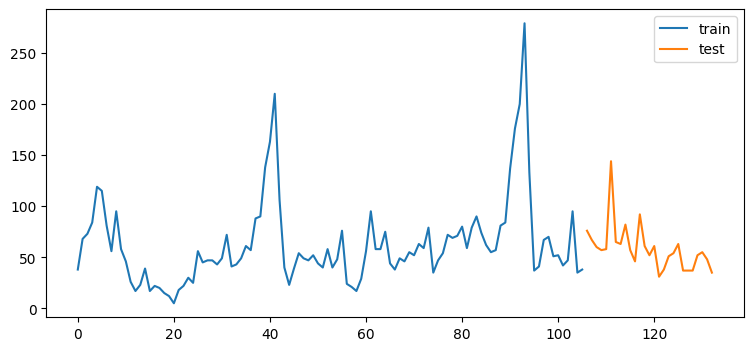

In [6]:
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
ax.legend();

In [6]:
datos_train

,SEMANA,ANO,PRENDA,UNIDADES,SEMANACORRIDA
0,1,2020,BLUSAS,38,1
1,2,2020,BLUSAS,68,2
2,3,2020,BLUSAS,73,3
3,4,2020,BLUSAS,84,4
4,5,2020,BLUSAS,119,5
...,...,...,...,...,...
101,9,2022,BLUSAS,42,115
102,10,2022,BLUSAS,47,116
103,11,2022,BLUSAS,95,117
104,12,2022,BLUSAS,35,118


In [7]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['UNIDADES'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 105] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-07 13:01:32 
Last fit date: 2022-12-07 13:01:32 
Skforecast version: 0.6.0 
Python version: 3.10.5 

In [9]:
# Predicciones
# ==============================================================================
steps = tam
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

106    47.95
107    52.27
108    53.66
109    58.02
110    58.53
Name: pred, dtype: float64

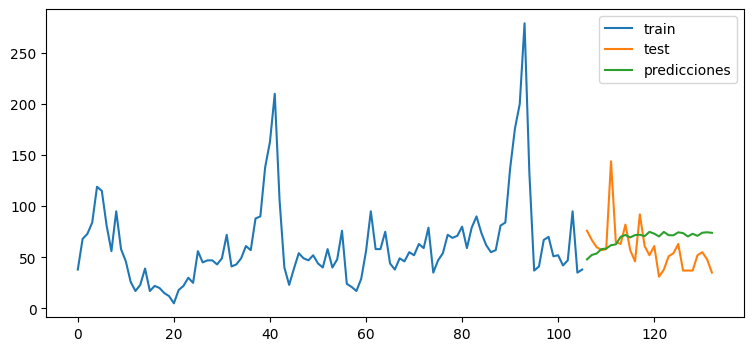

In [10]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [11]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['UNIDADES'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 755.5402037037037


In [12]:
# Grid search de hiperparámetros
# ==============================================================================
steps = tam
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [1, 52]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [1, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['UNIDADES'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:15<00:00,  7.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1979.659181345142



In [13]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,[1],"{'max_depth': 5, 'n_estimators': 500}",1979.659181,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",2060.940759,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",2061.427605,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",2073.606810,10,500
1,[1],"{'max_depth': 3, 'n_estimators': 500}",2076.336184,3,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 1}",2138.905660,10,1
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 1}",2148.901887,5,1
0,[1],"{'max_depth': 3, 'n_estimators': 1}",2192.206965,3,1
2,[1],"{'max_depth': 5, 'n_estimators': 1}",2252.461739,5,1
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 1}",2303.797555,3,1


In [14]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['UNIDADES'])

In [15]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

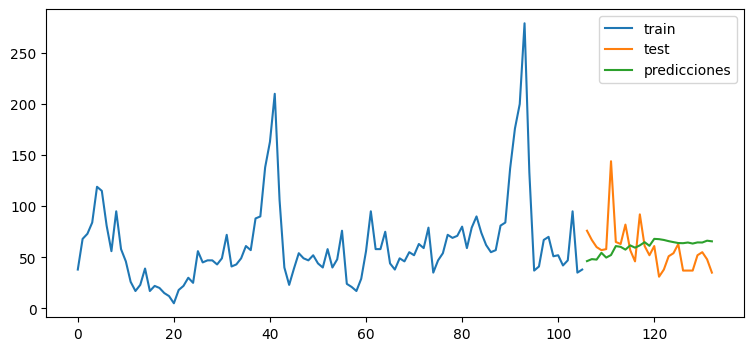

In [16]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [17]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['UNIDADES'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 666.6637629574324


In [18]:
# Backtesting
# ==============================================================================
steps = tam
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df['UNIDADES'],
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25
Number of observations used for backtesting: 108
    Number of folds: 4
    Number of steps per fold: 27

Data partition in fold: 0
    Training:   0 -- 24  (n=25)
    Validation: 25 -- 51  (n=27)
Data partition in fold: 1
    Training:   0 -- 51  (n=52)
    Validation: 52 -- 78  (n=27)
Data partition in fold: 2
    Training:   0 -- 78  (n=79)
    Validation: 79 -- 105  (n=27)
Data partition in fold: 3
    Training:   0 -- 105  (n=106)
    Validation: 106 -- 132  (n=27)

Error de backtest: 2285.9331861801265


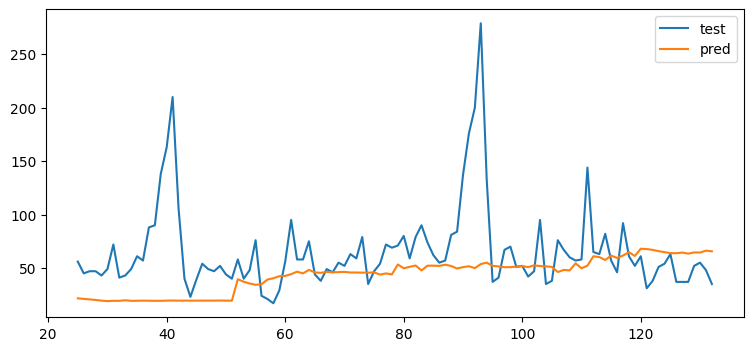

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
df.loc[predicciones_backtest.index, 'UNIDADES'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

In [20]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.720890
1,lag_2,0.022800
2,lag_3,0.014766
3,lag_4,0.009233
4,lag_5,0.010918
5,lag_6,0.009139
6,lag_7,0.007219
7,lag_8,0.010298
8,lag_9,0.018694
9,lag_10,0.017408


In [11]:
from predPrenda import predictPrenda
from proyectoprincipal import predictInve

In [12]:
def cambiobase(num):
    j=0;
    for i in range(num):
        j=j+1;
        if(j==53):
            j=0;
    return j

In [13]:
tam2 = len(datos_test)
tam2
arr = []
a = datos_test.iloc [:, 4].values
    

In [52]:
for i in range(tam2):
    c = cambiobase(a[i])
    #print(c)
    er = predictPrenda('MOLINOS 1', c, 'BLUSAS')
    #print(er.values[0])
    arr.append(er.values[0])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [53]:
pa = arr[0]
pa.values[0]

77.0

In [54]:
arr[0].values[0]

77.0

In [55]:
a = datos_test.iloc [:, 4].values
a[0]

120

In [30]:
a

array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146], dtype=int64)

In [65]:
c= a[0].item()
c

120

In [66]:
type(c)

int

In [100]:
# c= a[0].item()
# # c= c.item()
b = predictPrenda('ARKADIA', 120, 'BLUSAS')
b.values

array([], dtype=object)

In [59]:
type(a[0].item())


int

In [62]:
b = a[0].item()
type(b)

int

In [63]:
b

120

In [55]:
type(c.item())

AttributeError: 'int' object has no attribute 'item'

In [161]:
a = predictPrenda('MOLINOS 1',49,'BLUSAS')
# a.values[0]
a

1    138.5
Name: UNIDADES, dtype: object

In [162]:
a = predictInve('MOLINOS 1', 49)
a

,PRENDA,UNIDADES
0,0,5.0
1,1,138.5
2,2,7.0
3,3,42.0
4,4,295.0
5,5,158.0
6,6,6.0
7,7,4.0
8,8,1238.0
9,9,135.0


KeyError: 'UNIDADES'